# Parse PATH monthly ridership PDF
```bash
papermill -p year $year [-p last_month $last_month] monthly.ipynb out/monthly-$year.ipynb
```

In [1]:
from utz import *
import json
from tabula import read_pdf
from path_data import paths
from path_data.paths import monthly_pdf, year_pqt, year_day_types_pqt, TEMPLATE_2023, TEMPLATE_2022

In [2]:
n = now()
cur_year = n.year
cur_month = n.month
cur_year, cur_month

(2025, 3)

Papermill parameters:

In [3]:
year = None
last_month = None
template = None

In [4]:
# Parameters
year = 2024


In [5]:
if year is None:
    year = cur_year

pdf = monthly_pdf(year)
relpath(pdf)

'data/2024-PATH-Monthly-Ridership-Report.pdf'

In [6]:
if last_month is None:
    from PyPDF2 import PdfReader

    reader = PdfReader(pdf)
    num_pages = len(reader.pages)
    last_month = num_pages - 1
    err(f"Inferred {last_month=}")

if template is None:
    template = paths.template(year)

Inferred last_month=12


In [7]:
with open(template, 'r') as f:
    rects = json.load(f)
rects

[{'page': 1,
  'extraction_method': 'guess',
  'x1': 54.315,
  'x2': 577.575,
  'y1': 116.00001000000002,
  'y2': 238.40001,
  'width': 523.26,
  'height': 122.4},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 58.14,
  'x2': 577.575,
  'y1': 253.000035,
  'y2': 401.41003500000005,
  'width': 519.4350000000001,
  'height': 148.41},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 58.14,
  'x2': 577.575,
  'y1': 474.999975,
  'y2': 592.809975,
  'width': 519.4350000000001,
  'height': 117.81},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 56.61,
  'x2': 578.34,
  'y1': 611.000145,
  'y2': 753.290145,
  'width': 521.73,
  'height': 142.29},
 {'page': 1,
  'extraction_method': 'guess',
  'x1': 273.87,
  'x2': 573.75,
  'y1': 60.8175,
  'y2': 107.4825,
  'width': 299.88,
  'height': 46.665}]

In [8]:
area = [ [ r[k] for k in [ 'y1', 'x1', 'y2', 'x2' ] ] for r in rects ]
area

[[116.00001000000002, 54.315, 238.40001, 577.575],
 [253.000035, 58.14, 401.41003500000005, 577.575],
 [474.999975, 58.14, 592.809975, 577.575],
 [611.000145, 56.61, 753.290145, 578.34],
 [60.8175, 273.87, 107.4825, 573.75]]

In [9]:
tables = {
    month: read_pdf(
        pdf,
        pages=month,
        area=area,
        pandas_options={'header': None},
        stream=True,
    ) 
    for month in range(1, last_month + 1)
}
tables

Failed to import jpype dependencies. Fallback to subprocess.
No module named 'jpype'


{1: [                    0          1       2       3       4       5
  0  Christopher Street     86,831   3,147   2,511   1,784   1,784
  1          9th Street     75,977   2,792   2,108   1,401   1,651
  2         14th Street    127,321   4,834   3,037   2,180   2,472
  3         23rd Street    122,336   5,033   1,964   1,287   1,817
  4         33rd Street    500,254  19,543   9,702   6,865  11,787
  5     UPTOWN SUBTOTAL    912,719  35,350  19,322  13,517  19,510
  6                 WTC    922,430  37,278  15,316  11,296  16,569
  7   NEW YORK SUBTOTAL  1,835,149  72,628  34,638  24,813  36,079,
                       0          1        2       3       4       5
  0               Newark    344,156   14,267   5,102   3,413   5,244
  1             Harrison    130,445    5,417   2,086   1,154   1,862
  2       Journal Square    474,171   18,174  10,822   7,634   9,348
  3         Grove Street    366,378   14,545   7,620   4,638   5,955
  4       Exchange Place    248,376   10,112   4

In [10]:
cols1 = [ 'station', 'total', 'avg weekday', 'avg sat', 'avg sun', 'avg holiday' ]
cols2 = [ 'station', 'avg daily', 'total weekday', 'total sat', 'total sun', 'total holiday' ]

In [11]:
for k, v in tables.items():
    n = len(v)
    msg = f'Pg {k}: {n} tables'
    if n == 5:
        print(msg)
    else:
        err(msg)
len(tables)

Pg 1: 5 tables
Pg 2: 5 tables
Pg 3: 5 tables
Pg 4: 5 tables
Pg 5: 5 tables
Pg 6: 5 tables
Pg 7: 5 tables
Pg 8: 5 tables
Pg 9: 5 tables
Pg 10: 5 tables
Pg 11: 5 tables
Pg 12: 5 tables


12

In [12]:
avgs = pd.concat([
    df.assign(date=date(year, month, 1)).astype({ 'date': 'datetime64[s]' })
    for month, dfs in tables.items()
    for df in dfs[:2]
])
avgs

,0,1,2,3,4,5,date
0,Christopher Street,"86,831","3,147","2,511","1,784","1,784",2024-01-01
1,9th Street,"75,977","2,792","2,108","1,401","1,651",2024-01-01
2,14th Street,"127,321","4,834","3,037","2,180","2,472",2024-01-01
3,23rd Street,"122,336","5,033","1,964","1,287","1,817",2024-01-01
4,33rd Street,"500,254","19,543","9,702","6,865","11,787",2024-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,"291,593","11,077","7,218","5,077","4,720",2024-12-01
5,Newport,"298,257","11,598","6,216","5,020","4,734",2024-12-01
6,Hoboken,"438,760","16,572","12,150","7,696","3,662",2024-12-01
7,NEW JERSEY SUBTOTAL,"2,608,864","99,279","63,756","46,467","36,642",2024-12-01


In [13]:
avgs.columns = cols1 + ['month']
avgs = avgs.assign(**{
    k: avgs[k].astype(str).str.replace(',', '').astype(int)
    for k in cols1[1:]
})
avgs

,station,total,avg weekday,avg sat,avg sun,avg holiday,month
0,Christopher Street,86831,3147,2511,1784,1784,2024-01-01
1,9th Street,75977,2792,2108,1401,1651,2024-01-01
2,14th Street,127321,4834,3037,2180,2472,2024-01-01
3,23rd Street,122336,5033,1964,1287,1817,2024-01-01
4,33rd Street,500254,19543,9702,6865,11787,2024-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,291593,11077,7218,5077,4720,2024-12-01
5,Newport,298257,11598,6216,5020,4734,2024-12-01
6,Hoboken,438760,16572,12150,7696,3662,2024-12-01
7,NEW JERSEY SUBTOTAL,2608864,99279,63756,46467,36642,2024-12-01


In [14]:
avgs.isna().sum(axis=0)

station        0
total          0
avg weekday    0
avg sat        0
avg sun        0
avg holiday    0
month          0
dtype: int64

In [15]:
avgs.dtypes

station               object
total                  int64
avg weekday            int64
avg sat                int64
avg sun                int64
avg holiday            int64
month          datetime64[s]
dtype: object

In [16]:
sums = pd.concat([
    df.assign(date=date(year, month, 1)).astype({ 'date': 'datetime64[s]' })
    for month, dfs in tables.items()
    for df in dfs[2:4]
])
sums

,0,1,2,3,4,5,date
0,Christopher Street,"2,801","66,085","10,043","7,136","3,567",2024-01-01
1,9th Street,"2,451","58,641","8,433","5,602","3,301",2024-01-01
2,14th Street,"4,107","101,507","12,149","8,721","4,944",2024-01-01
3,23rd Street,"3,946","105,700","7,855","5,147","3,634",2024-01-01
4,33rd Street,"16,137","410,413","38,806","27,461","23,574",2024-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,"9,406","232,614","28,873","25,386","4,720",2024-12-01
5,Newport,"9,621","243,560","24,862","25,101","4,734",2024-12-01
6,Hoboken,"14,154","348,016","48,600","38,482","3,662",2024-12-01
7,NEW JERSEY SUBTOTAL,"84,157","2,084,864","255,023","232,335","36,642",2024-12-01


In [17]:
sums.columns = cols2 + ['month']
sums = sums.assign(**{
    k: sums[k].astype(str).str.replace(',', '').astype(int)
    for k in cols2[1:]
})
sums

,station,avg daily,total weekday,total sat,total sun,total holiday,month
0,Christopher Street,2801,66085,10043,7136,3567,2024-01-01
1,9th Street,2451,58641,8433,5602,3301,2024-01-01
2,14th Street,4107,101507,12149,8721,4944,2024-01-01
3,23rd Street,3946,105700,7855,5147,3634,2024-01-01
4,33rd Street,16137,410413,38806,27461,23574,2024-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,9406,232614,28873,25386,4720,2024-12-01
5,Newport,9621,243560,24862,25101,4734,2024-12-01
6,Hoboken,14154,348016,48600,38482,3662,2024-12-01
7,NEW JERSEY SUBTOTAL,84157,2084864,255023,232335,36642,2024-12-01


In [18]:
sums.isna().sum(axis=0)

station          0
avg daily        0
total weekday    0
total sat        0
total sun        0
total holiday    0
month            0
dtype: int64

In [19]:
sums.dtypes

station                 object
avg daily                int64
total weekday            int64
total sat                int64
total sun                int64
total holiday            int64
month            datetime64[s]
dtype: object

In [20]:
def parse_nums(month, tbl):
    assert len(tbl) == 3
    assert all(tbl.iloc[0] == 'Average')
    tbl.columns = tbl.iloc[1].str.lower()
    tbl.columns.name = None
    tbl = tbl.iloc[2:]
    tbl.index = [month]
    tbl.index.name = 'month'
    return tbl.astype(int)
    
nums = pd.concat([
    parse_nums(month=month, tbl=dfs[-1])
    for month, dfs in tables.items()
])
nums.columns = [ f'{c}s' for c in nums.columns ]
nums

,weekdays,saturdays,sundays,holidays
month,,,,
1,21,4,4,2
2,20,4,4,1
3,21,5,5,0
4,22,4,4,0
5,22,4,4,1
6,19,5,5,1
7,22,4,4,1
8,22,5,4,0
9,20,4,5,1


In [21]:
df = sxs(
    avgs.set_index(['month', 'station']),
    sums.set_index(['month', 'station']),
)
df = df[[cols2[1]] + cols1[2:] + [cols1[1]] + cols2[2:]]
df

avg daily  avg weekday  avg sat  avg sun  \
month      station                                                         
2024-01-01 Christopher Street        2801         3147     2511     1784   
           9th Street                2451         2792     2108     1401   
           14th Street               4107         4834     3037     2180   
           23rd Street               3946         5033     1964     1287   
           33rd Street              16137        19543     9702     6865   
...                                   ...          ...      ...      ...   
2024-12-01 Exchange Place            9406        11077     7218     5077   
           Newport                   9621        11598     6216     5020   
           Hoboken                  14154        16572    12150     7696   
           NEW JERSEY SUBTOTAL      84157        99279    63756    46467   
           MONTHLY TOTAL           154786       181904   116866    88262   

                                avg holiday    total  total weekday  \
month      station                                                    
2024-01-01 Christopher Street          1784    86831          66085   
           9th Street                  1651    75977          58641   
           14th Street                 2472   127321         101507   
           23rd Street                 1817   122336         105700   
           33rd Street                11787   500254         410413   
...                                     ...      ...            ...   
2024-12-01 Exchange Place              4720   291593         232614   
           Newport                     4734   298257         243560   
           Hoboken                     3662   438760         348016   
           NEW JERSEY SUBTOTAL        36642  2608864        2084864   
           MONTHLY TOTAL              69629  4798377        3819974   

                                total sat  total sun  total holiday  
month      station                                                   
2024-01-01 Christopher Street       10043       7136           3567  
           9th Street                8433       5602           3301  
           14th Street              12149       8721           4944  
           23rd Street               7855       5147           3634  
           33rd Street              38806      27461          23574  
...                                   ...        ...            ...  
2024-12-01 Exchange Place           28873      25386           4720  
           Newport                  24862      25101           4734  
           Hoboken                  48600      38482           3662  
           NEW JERSEY SUBTOTAL     255023     232335          36642  
           MONTHLY TOTAL           467462     441312          69629  

[204 rows x 10 columns]

In [22]:
path = year_pqt(year)
df.to_parquet(path)
err(f"Wrote {relpath(path)}")

Wrote data/2024.pqt


In [23]:
nums_path = year_day_types_pqt(year)
nums.to_parquet(nums_path)
err(f"Wrote {relpath(nums_path)}")

Wrote data/2024-day-types.pqt


In [24]:
import plotly.express as px
from IPython.display import Image

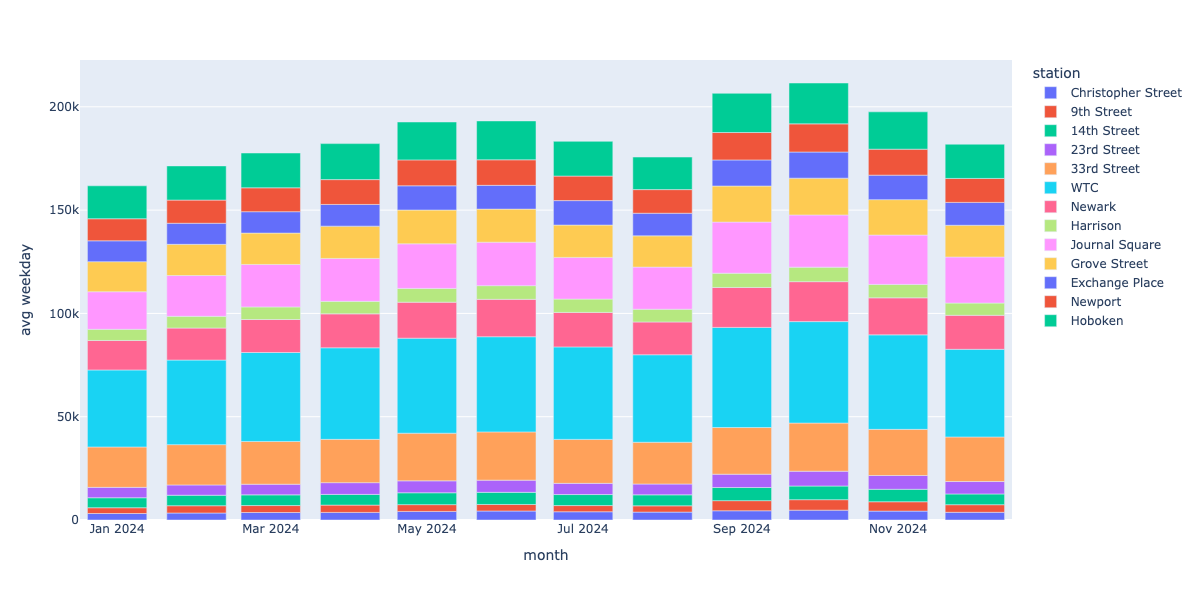

In [25]:
fig = px.bar(
    avgs[~avgs.station.str.contains('TOTAL')],
    x='month', y='avg weekday', color='station',
)
Image(fig.to_image(width=1200, height=600))